### Import drive library and mount the drive.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import general libraies used in project

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

## Loading data



In [4]:
tws = pd.read_csv('/content/drive/My Drive/MLAI/Tweets.csv')
tws.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


 # Understanding the data

In [5]:
tws.shape

(14640, 15)

In [6]:
tws.isna().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [7]:
tws = tws.drop(['airline_sentiment_gold','negativereason_gold','tweet_coord'], axis = 1)

In [8]:
tws.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


## Check for sentiment data distribution by air line to understand better the data

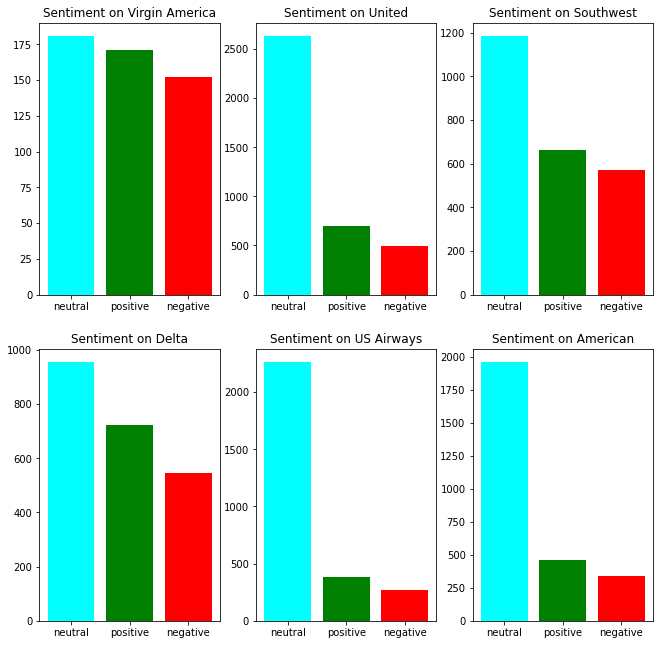

In [9]:
ind = 1
cats = tws.airline_sentiment.unique()
scaleColors = ['cyan', 'green', 'red']
plt.figure(1,figsize=(11, 11))


for i in tws.airline.unique():
    plt.subplot(2,3,ind)
    plt.bar(cats,tws[tws['airline']==i].groupby(by='airline', axis=0).airline_sentiment.value_counts(),color=scaleColors)
    plt.title('Sentiment on '+ i)
    ind+=1
    

# Data Selection

In [10]:
# Using just text and airlinea_sentiment to process
twData = tws[['text','airline_sentiment']].copy()

In [11]:
twData.shape

(14640, 2)

In [12]:
twData.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


# Text pre-processing:Data preparation

In [13]:
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import re
import unicodedata
import spacy
from bs4 import BeautifulSoup

## Download stopwords and eliminate negative words to achive a better sentiment analysis.

In [15]:
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english')) 
# Make a custome list of stop words, so not removing negative words from original data.
customlist = ['not', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn',
        "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
        "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
        "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
stopwords = list(set(stopwords) - set(customlist))    


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#### Remove HTML tags and @Accounts

In [16]:
def strip_text_html(text):
    text = re.sub(r'@\S+', '', text)
    soup  = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

#### Remove Accented 

In [17]:
def remove_accented_chars(text):
    return unicodedata.normalize('NFKD',text).encode('ascii','ignore').decode('utf-8','ignore')

#### Remove numers 

In [18]:
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

#### Remove Special Characters 

In [19]:
def remove_special_chars(text, remove_digits = False):
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]'
    return re.sub(pattern, '', text)

#### Lemmatization

In [20]:
npl = spacy.load('en_core_web_sm', parse=True, tag=True, entity=True)

def lemmatize_text(text):
    text = npl(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

#### Stemmig

In [21]:
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

#### Tokenization and lower case

In [22]:
def Tokenizeme(text):
    tokenizer = ToktokTokenizer()
    return tokenizer.tokenize(text.lower())

#### Remove Stop Words

In [23]:
def removeStopWords(text):
    return [t for t in text if not t in stopwords]  

#### Pre-processing Text

In [24]:
def preProcess(text):
    review_text = strip_text_html(text) 
    
    letters_only = remove_accented_chars(review_text)
    letters_only = remove_numbers(letters_only)
    letters_only = remove_special_chars(letters_only)
             
    words = Tokenizeme(letters_only)
    meaningWords = removeStopWords(words)
    return( " ".join( meaningWords ))  

# Apply all pre-processing to text data

In [25]:
twData.text = twData.text.apply(lambda x:preProcess(x))

## Apply Lemmatize processing 

In [26]:
FAST_stemming = False
#if FAST_stemming is TRUE then Steamming is used, otherwise lemmatize is used.

if FAST_stemming:
    twData.text = twData.text.apply(lambda x:simple_stemmer(x))
else:
    twData.text = twData.text.apply(lambda x:lemmatize_text(x))

In [27]:
twData.head()

,text,airline_sentiment
0,say,neutral
1,plus you have add commercial experience tacky,positive
2,do not today must mean nee take another trip,neutral
3,really aggressive blast obnoxious entertainmen...,negative
4,really big bad thing,negative


In [28]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [29]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_data = tfidf_vectorizer.fit_transform(twData.text)
tfidf_data = tfidf_data.toarray()

In [30]:
tfidf_data.shape

(14640, 12019)

In [31]:
cv_vectorizer = CountVectorizer()
cv_data = cv_vectorizer.fit_transform(twData.text)
cv_data = cv_data.toarray()

In [32]:
cv_data.shape

(14640, 12019)

# Hot encoding airline_sentiment

In [33]:
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')

senntiments = twData['airline_sentiment'].unique()
le = preprocessing.LabelEncoder()
le.fit(senntiments)
twData.airline_sentiment = le.transform(twData.airline_sentiment)

In [34]:
cvX = cv_data
tfX = tfidf_data
y = twData.airline_sentiment

## Split data into test and train data

In [35]:
from sklearn.model_selection import train_test_split
cvxtrain, cvxtest, cvytrain, cvytest = train_test_split(cvX, y, test_size=0.3, random_state=74)
tfxtrain, tfxtest, tfytrain, tfytest = train_test_split(tfX, y, test_size=0.3, random_state=74)

# Import libraries for train the models

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from yellowbrick.classifier import ConfusionMatrix, ClassificationReport, ROCAUC
import seaborn as sns


## Define a list of model to train

In [37]:
Classifiers = [RandomForestClassifier(n_estimators=100),
               AdaBoostClassifier(),
               GaussianNB()]

## Create a function to train any model and plot its ROC AUC and Confusion matrix

In [38]:
def anyModelFit(name, model, xtrain, ytrain, xtest, ytest):
    global results
    global ax 
    
    #fitting the model and getting its predictions
    model.fit(xtrain, ytrain)
    pred = model.predict(xtest)
    
    #getting performance metrics
    scoreTr = model.score(xtrain, ytrain)
    scoreTs = model.score(xtest, ytest)
    acc = accuracy_score(ytest, pred)    
    prec = precision_score(ytest, pred, average='weighted', zero_division = 0)

    #visualizations of ROCAUC
    viz = ROCAUC(model, ax=axes[ax][0])
    viz.fit(xtrain, ytrain)
    viz.score(xtest, ytest)
    viz.finalize()

    #visualize the confusion matrix
    cm = confusion_matrix(ytest, pred)
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=['neutral', 'positive', 'negative'], yticklabels=['neutral', 'positive', 'negative'],  ax=axes[ax][1])   
    
    
    dd = {'Method':name, 'ScoreTrain':scoreTr, 'ScoreTest':scoreTs, 'Acuracy':acc, 'Precision': prec}
    results = results.append(dd, ignore_index=True)
    
        
    ax = ax + 1

## Train the models and show its ROC Curves and Confusion Matrix with Couter Vectorized data

Model: RandomForestClassifier
Model: AdaBoostClassifier
Model: GaussianNB


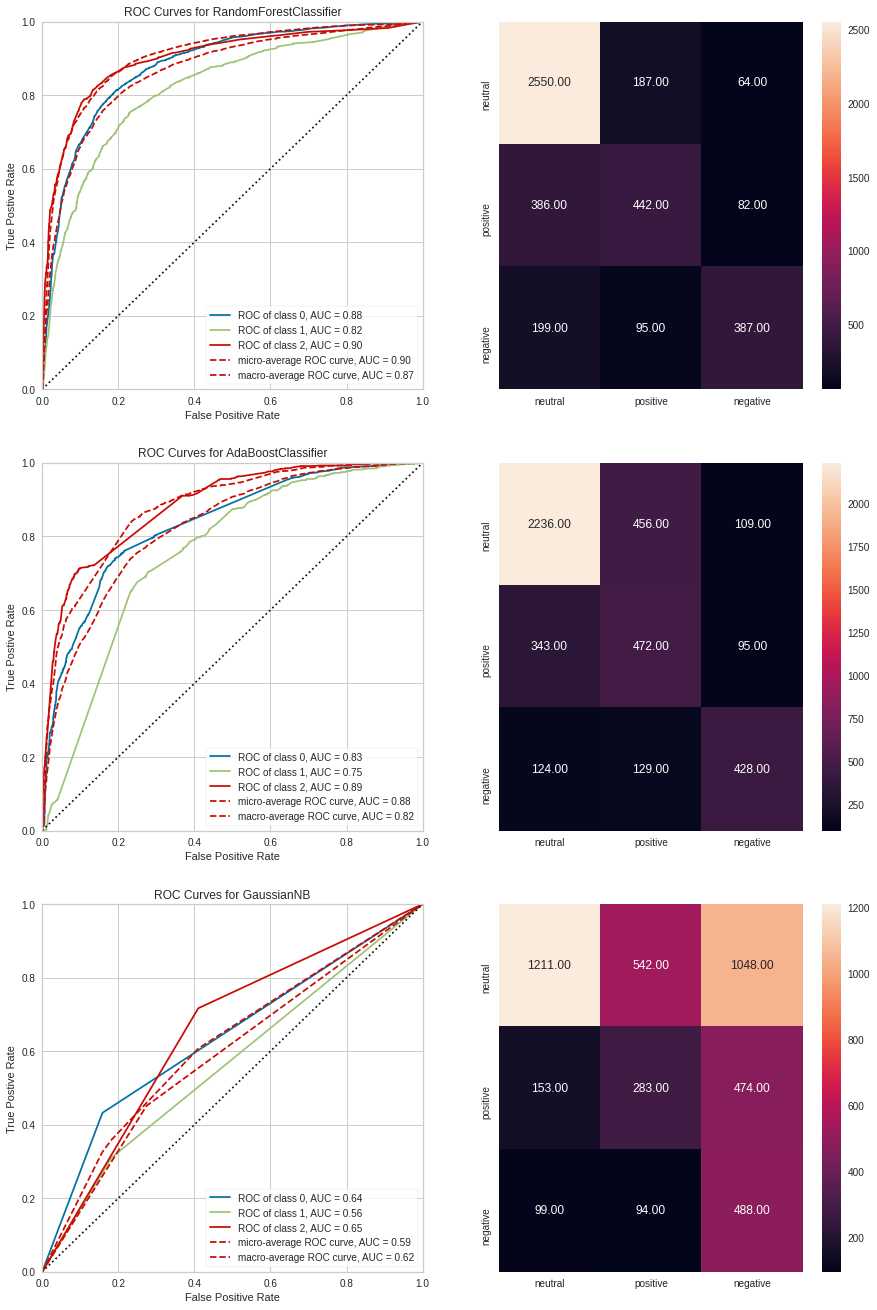

,Method,ScoreTrain,ScoreTest,Acuracy,Precision
0,RandomForestClassifier,0.994438,0.769353,0.769353,0.757818
1,AdaBoostClassifier,0.724824,0.714026,0.714026,0.725093
2,GaussianNB,0.705016,0.451275,0.451275,0.629348


In [39]:
results = pd.DataFrame(columns=['Method', 'ScoreTrain', 'ScoreTest', 'Acuracy', 'Precision'])
fig, axes = plt.subplots(len(Classifiers), 2, figsize=(15,23))
ax = 0

for model in Classifiers:
    model_name = model.__class__.__name__
    print('Model: {}'.format(model_name))
    anyModelFit(model_name, model, cvxtrain , cvytrain, cvxtest, cvytest)

plt.show()
results

## Train the models and show its ROC Curves and Confusion Matrix with Tf-IDF Vectorized data

Model: RandomForestClassifier
Model: AdaBoostClassifier
Model: GaussianNB


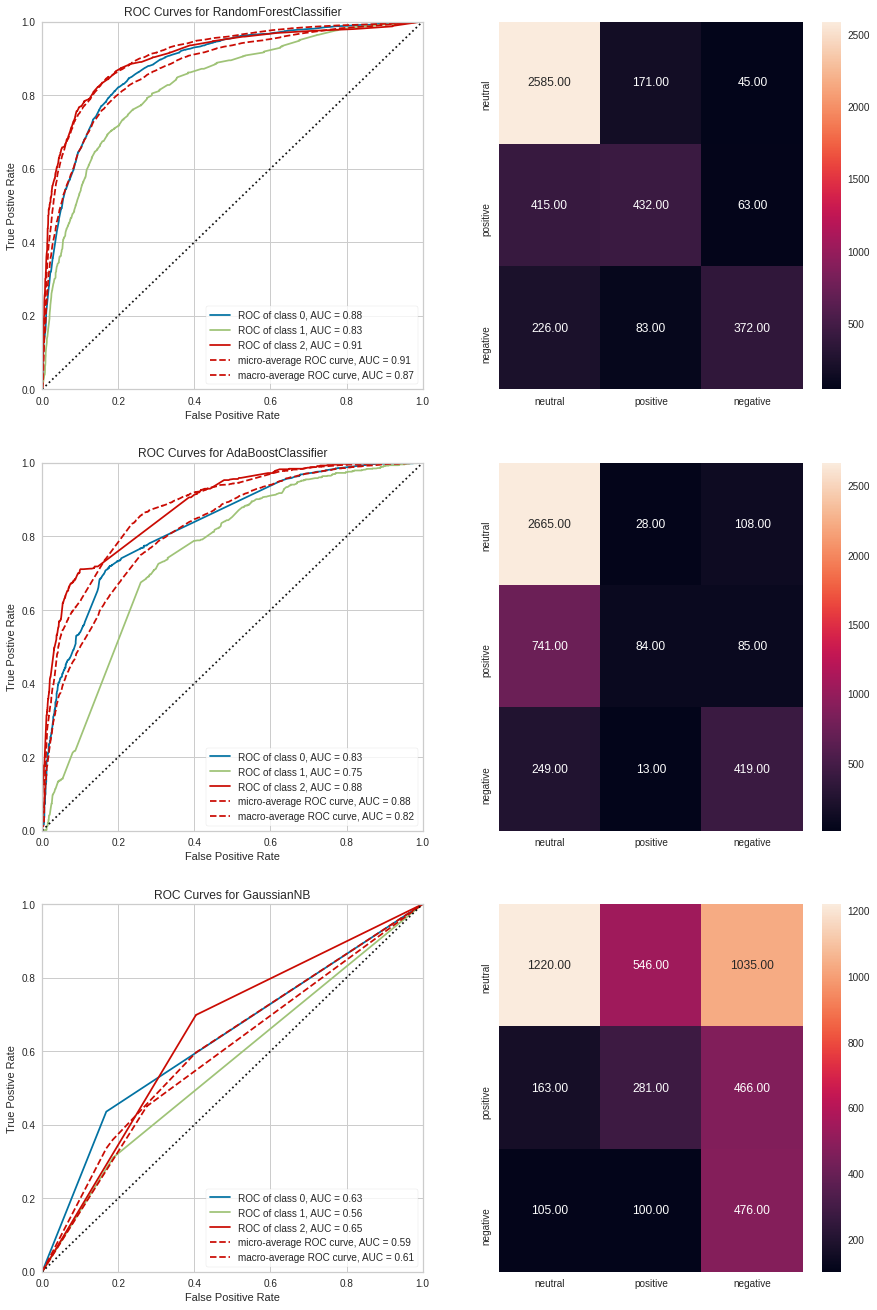

,Method,ScoreTrain,ScoreTest,Acuracy,Precision
0,RandomForestClassifier,0.994438,0.771630,0.771630,0.761676
1,AdaBoostClassifier,0.723361,0.721311,0.721311,0.710400
2,GaussianNB,0.705308,0.450137,0.450137,0.623026


In [40]:
results = pd.DataFrame(columns=['Method', 'ScoreTrain', 'ScoreTest', 'Acuracy', 'Precision'])
fig, axes = plt.subplots(len(Classifiers), 2, figsize=(15,23))
ax = 0

for model in Classifiers:
    model_name = model.__class__.__name__
    print('Model: {}'.format(model_name))
    anyModelFit(model_name, model, tfxtrain, tfytrain, tfxtest,  tfytest)

plt.show()
results

### Conclusion:

The work of preprocessing the text data is very easy to carry out, with the only detail that the Stemming process is very slow compared to the Stemming process.
In the case of sentiment analysis (negative, positive and neutral), it is important not to eliminate the words that identify negative feelings.
With the use of vectorization processes: CountVectorize and TfidfVectorizer for this exercise, there is no big difference in the results obtained. The difference is not even 1%.

3 classification models were used, of which the method: RandomForestClassifier was the one that had the best performance with 77.16% accuracy with the test data.